In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import bokeh.transform
import bokeh.models
import bokeh.plotting
import bokeh.layouts
import bokeh.embed
import bokeh.io

import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data.db_wetter2 as db

bokeh.io.output_notebook()

Loading BokehJS ...

In [1]:
daily_average = db.extract_average_weather()
daily_average

NameError: name 'db' is not defined

In [12]:
def energy_grouped_bar_plot(daily_results):
    fig, ax = plt.subplots()

    color = "#BBBBBB #F0E442 #D55E00 #009E73 #0072B2 #56B4E9".split()

    avg_daily_production = daily_results.iloc[:, :-1].groupby(daily_results.index.year).mean()
    avg_daily_production.plot.bar(ax=ax, color=color)

    ax.set_ylabel('Average Energy Production [MW]')
    ax.set_title('Average Energy Production by Year and Source')
    ax.legend()

    return fig

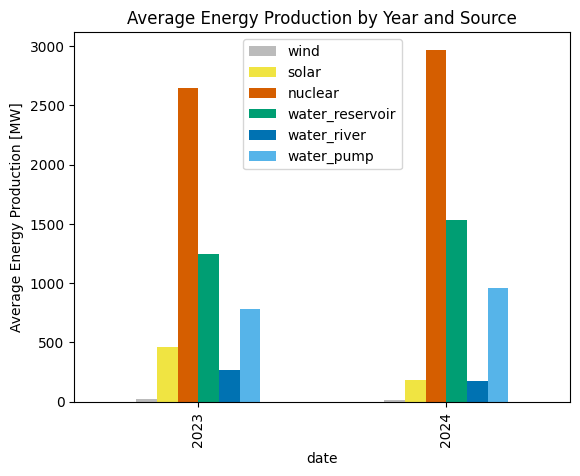

In [13]:
bar_plot = energy_grouped_bar_plot(daily_results)

In [14]:
def energy_stacked_area_plot(raw_results, daily_results):
    
    hourly_source = bokeh.models.ColumnDataSource(data=raw_results)
    day_source = bokeh.models.ColumnDataSource(data=daily_results)
    
    column_names = "nuclear solar wind water_reservoir water_river water_pump".split()
    colors = "#D55E00 #F0E442 #BBBBBB #009E73 #0072B2 #56B4E9".split()
    
    middle = len(raw_results)//2
    selection_range = 500
    
    # Range-Plot
    range_plot = bokeh.plotting.figure(
        height=300, 
        width=800, 
        x_axis_type="datetime", 
        x_axis_location="above", 
        x_range=(raw_results.index[middle-selection_range], raw_results.index[middle+selection_range]),
        y_axis_label = "Energy Production [MW]",
    )
    

    # Range-Plot on daily base
    daily_plot = range_plot.varea_stack(
        x='date',
        stackers=column_names,
        source=day_source,    
        color=colors,
        legend_label=column_names,
    )

    
    # Range-Plot on hourly base
    hourly_plot = range_plot.varea_stack(
        x='datetime',
        stackers=column_names,
        source=hourly_source,    
        color=colors,
        legend_label=column_names,
        visible=False,
    )

    range_plot.legend.location = "top_left"
    

    # Plot-Selector
    # to change visibility of daily_plot and hourly_plot
    plot_selector = bokeh.models.RadioButtonGroup(labels=["Stündlich", "Täglich"], active=1)
    plot_selector.js_on_event(
        "button_click", 
        bokeh.models.CustomJS(
            args=dict(
                btn=plot_selector,
                hplot=hourly_plot,
                dplot=daily_plot,
            ),
            code="""
        console.log('radio_button_group: active=' + btn.active, this.toString())    
        let plots=[hplot, dplot]
        plots.forEach(p => p.forEach(q => {q.visible=false}))
        plots[btn.active].forEach(q => {q.visible=true})
    """)
    )

    # Range-Tool
    # for the Overview-Plot
    range_tool = bokeh.models.RangeTool(x_range=range_plot.x_range)
    range_tool.overlay.fill_color = "navy"
    range_tool.overlay.fill_alpha = 0.2

    
    # Overview-Plot
    overview_plot = bokeh.plotting.figure(
        title="Drag the middle and edges of the selection box to change the range above",
        height=130, 
        width=800, 
        y_range=range_plot.y_range,
        x_axis_type="datetime",
        y_axis_type=None,
        toolbar_location=None, 
    )
    
    overview_plot.varea_stack(
        x='date',
        stackers=column_names,
        source=day_source,    
        color=colors,
    )
   
    overview_plot.add_tools(range_tool)
    
    # Create Figure
    overview_fig = bokeh.layouts.column(plot_selector, range_plot, overview_plot)
    
    # Plot Figure in Notebook
    bokeh.plotting.show(overview_fig)

    return overview_fig

In [15]:
stacked_area_plot = energy_stacked_area_plot(raw_results, daily_results)

In [16]:
def energy_yearly_pie_plot(daily_results):
    years = set(daily_results.index.year)
    for year in years:
        
        yearly_results = daily_results[daily_results.index.year == year]
        
        x = round(yearly_results.iloc[:,:-1].sum()/1000, 2)
        
        data = pd.Series(x).reset_index(name='value').rename(columns={'index': 'country'})
        data['angle'] = data['value']/data['value'].sum() * 2*math.pi
        data['color'] = "#BBBBBB #F0E442 #D55E00 #009E73 #0072B2 #56B4E9".split()
        
        pie_plot = bokeh.plotting.figure(
            height=350, 
            title=f"Yearly Production by Energy-Type in GWh in {year}", 
            toolbar_location=None,
            tools="hover", 
            tooltips="@country: @value", 
            x_range=(-0.5, 1.0),
        )
        
        pie_plot.wedge(
            x=0, 
            y=1, 
            radius=0.4,
            start_angle=bokeh.transform.cumsum('angle', include_zero=True), 
            end_angle=bokeh.transform.cumsum('angle'),
            line_color="white", 
            fill_color='color', 
            legend_field='country', 
            source=data,
        )
        
        pie_plot.axis.axis_label = None
        pie_plot.axis.visible = False
        pie_plot.grid.grid_line_color = None
        
        yearly_pie_fig = bokeh.layouts.column(pie_plot)

        #Plot Figure in Notebook
        bokeh.plotting.show(yearly_pie_fig)

    return yearly_pie_fig

In [17]:
pie_plot = energy_yearly_pie_plot(daily_results)